In [7]:
# %load_ext autoreload
# %autoreload 2
import cv2
from pytorch_model_summary import summary
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
from cnn import CnnNet
from FireRecognitionDataset import FireRecognitionDataset
from sklearn.metrics import confusion_matrix
import torch

# %config InlineBackend.figure_format = 'svg'

In [8]:
dataset = FireRecognitionDataset()
criterion = nn.NLLLoss()


['fire_images', 'non_fire_images']


In [9]:
net = CnnNet(224, 2,  c_kernels=[7, 5, 5, 5, 3, 3], in_channels=[
    3, 32, 64, 128, 256, 256], out_channels=[32, 64, 128, 256, 256, 256], padding_flag=True,
    maxpool_freq=2, fc_size=3)
lr = 0.0001
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
loss_test = []

layer size: 2
output size: 59


In [10]:
if torch.cuda.is_available():
    net = net.cuda()
    net.cnn = net.cnn.cuda()
    print("GPU is available")
else:
    torch.device("cpu")
    print("GPU not available, CPU used")


GPU is available


In [11]:
def test(dataset, model, criterion):
    total = 0.
    predicted = 0.
    loss_test = 0.
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, labels in dataset.testloader:
            labels = labels.cuda()
            data = data.cuda()
            out = model(data)
            predicted_output = torch.argmax(out, dim=1)

            y_true = np.append(y_true, labels.cpu().detach().numpy(), 0)
            y_pred = np.append(y_pred, predicted_output.cpu().detach().numpy(), 0)
            total += labels.shape[0]
            predicted += torch.sum(predicted_output == labels).cpu().item()

            loss = criterion(out, labels)
            loss_test += loss.cpu().item()
    cf = confusion_matrix(y_true, y_pred)
    return (predicted/total*100), loss_test, cf


In [13]:
old_loss = 0
loss_training = []
for e in range(5):
    loss_temp = 0
    # pass through all data
    for data, exp in dataset.trainloader:
        exp = exp.cuda()
        # pass data to cuda
        data = data.cuda()
        # clear gradient from previous epoch
        optimizer.zero_grad()
        out = net(data)
        loss = criterion(out, exp)
        loss.backward()
        loss_temp += loss.item()
        optimizer.step()

    loss_training.append(loss_temp)
    acc, loss_test, mat = test(dataset, net, criterion)
    old_loss = loss_training[-1]

    # ax= plt.subplot()
    # sns.heatmap(mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
    # ax.set_title('Confusion Matrix');
    # ax.xaxis.set_ticklabels(['1', '2']); ax.yaxis.set_ticklabels(['1', '2']);
    # plt.show()

    temp_lr: float = optimizer.param_groups[0]['lr']
    print("acc: {:.2f} %".format(acc))
    print("Learning rate: {:.10f}".format(temp_lr))
    print("Epoch: {}.............".format(e), end=" ")
    print("Loss: {:.4f}".format(loss))
    # if acc > 80.0:
    #     break

torch.save(net.state_dict(), "fire_recognition")


acc: 95.31 %
Learning rate: 0.0001000000
Epoch: 0............. Loss: 0.1427
acc: 98.44 %
Learning rate: 0.0001000000
Epoch: 1............. Loss: 0.0001
acc: 100.00 %
Learning rate: 0.0001000000
Epoch: 2............. Loss: 0.3805
acc: 98.44 %
Learning rate: 0.0001000000
Epoch: 3............. Loss: 0.0000
acc: 95.31 %
Learning rate: 0.0001000000
Epoch: 4............. Loss: 0.0000


In [14]:
model = CnnNet(224, 2,  c_kernels=[7, 5, 5, 5, 3, 3], in_channels=[
    3, 32, 64, 128, 256, 256], out_channels=[32, 64, 128, 256, 256, 256], padding_flag=True,
    maxpool_freq=2, fc_size=3)
model.load_state_dict(torch.load("fire_recognition"))
model.eval()

classes = ["fire_images", "non_fire_images"]

layer size: 2
output size: 59


In [15]:
if torch.cuda.is_available():
    model = model.cuda()
    model.cnn = model.cnn.cuda()
    print("GPU is available")
else:
    torch.device("cpu")
    print("GPU not available, CPU used")


GPU is available


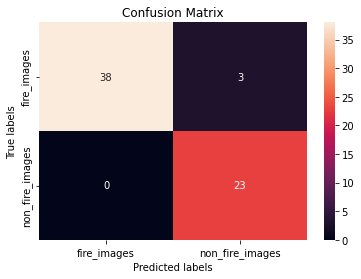

In [17]:
acc, loss_test, mat = test(dataset, model, criterion)

ax = plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax)  # annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["fire_images", "non_fire_images"])
ax.yaxis.set_ticklabels(["fire_images", "non_fire_images"])
plt.show()


In [20]:
img = cv2.imread('./fire.13.png')
img = np.moveaxis(img, -1, 0)
img = torch.from_numpy(img).unsqueeze(0).float()

with torch.no_grad():
    img = img.cuda()
    out = model(img)
    predicted_output = torch.argmax(out, dim=1)

print(classes[predicted_output])


fire_images


: 